In [1]:
from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import lookuptable_decoding
from qiskit.ignis.verification.topological_codes import GraphDecoder
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
aer_sim = Aer.get_backend('aer_simulator')

Let us start with the smallest non-trivial case: three repetitions and one syndrome measurement round. The circuits for the repetition code can then be created automatically from using the RepetitionCode object from Qiskit-Ignis.

In [2]:
n = 3
T = 1
code = RepetitionCode(n, T)

The RepetitionCode contains two quantum circuits that implement the code: One for each of the two possible logical bit values. Here are those for logical 0 and 1, respectively.

In [3]:
code.circuit['0'].draw()

┌───┐     ┌───┐        ┌─┐         
      link_qubit_0: ┤ X ├─────┤ X ├────────┤M├─────────
                    └─┬─┘┌───┐└─┬─┘┌───┐   └╥┘┌─┐      
      link_qubit_1: ──┼──┤ X ├──┼──┤ X ├────╫─┤M├──────
                      │  └─┬─┘  │  └─┬─┘┌─┐ ║ └╥┘      
      code_qubit_0: ──■────┼────┼────┼──┤M├─╫──╫───────
                           │    │    │  └╥┘ ║  ║ ┌─┐   
      code_qubit_1: ───────■────■────┼───╫──╫──╫─┤M├───
                                     │   ║  ║  ║ └╥┘┌─┐
      code_qubit_2: ─────────────────■───╫──╫──╫──╫─┤M├
                                         ║  ║  ║  ║ └╥┘
round_0_link_bit: 2/═════════════════════╬══╩══╩══╬══╬═
                                         ║  0  1  ║  ║ 
                                         ║        ║  ║ 
        code_bit: 3/═════════════════════╩════════╩══╩═
                                         0        1  2

In [4]:
code.circuit['1'].draw()

┌───┐     ┌───┐        ┌─┐         
      link_qubit_0: ─────┤ X ├─────┤ X ├────────┤M├─────────
                         └─┬─┘┌───┐└─┬─┘┌───┐   └╥┘┌─┐      
      link_qubit_1: ───────┼──┤ X ├──┼──┤ X ├────╫─┤M├──────
                    ┌───┐  │  └─┬─┘  │  └─┬─┘┌─┐ ║ └╥┘      
      code_qubit_0: ┤ X ├──■────┼────┼────┼──┤M├─╫──╫───────
                    ├───┤       │    │    │  └╥┘ ║  ║ ┌─┐   
      code_qubit_1: ┤ X ├───────■────■────┼───╫──╫──╫─┤M├───
                    ├───┤                 │   ║  ║  ║ └╥┘┌─┐
      code_qubit_2: ┤ X ├─────────────────■───╫──╫──╫──╫─┤M├
                    └───┘                     ║  ║  ║  ║ └╥┘
round_0_link_bit: 2/══════════════════════════╬══╩══╩══╬══╬═
                                              ║  0  1  ║  ║ 
                                              ║        ║  ║ 
        code_bit: 3/══════════════════════════╩════════╩══╩═
                                              0        1  2

In these circuits, we have two types of physical qubits. There are the 'code qubits', which are the three physical qubits across which the logical state is encoded. There are also the 'link qubits', which serve as the auxiliary qubits for the syndrome measurements.

Our single round of syndrome measurements in these circuits consist of just two syndrome measurements. One compares code qubits 0 and 1, and the other compares code qubits 1 and 2. One might expect that a further measurement, comparing code qubits 0 and 2, should be required to create a full set. However, these two are sufficient. This is because of the information on whether 0 and 2 have the same z basis state can be inferred from the same information about 0 and 1 with that for 1 and 2. **Indeed, for  
n qubits, we can get the required information from just n-1 syndrome measurements of neighbouring pairs of qubits.**

Running these circuits on a simulator without any noise leads to very simple results.

In [5]:
def get_raw_results(code,noise_model=None):
    circuits = code.get_circuit_list()
    raw_results = {}
    for log in range(2):
        qobj = assemble(circuits[log])
        job = aer_sim.run(qobj, noise_model=noise_model)
        raw_results[str(log)] = job.result().get_counts(str(log))
    return raw_results

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical', log, ':', raw_results[log], '\n')

Logical 0 : {'000 00': 1024} 

Logical 1 : {'111 00': 1024} 



Here we see that the output comes in two parts. The part on the right holds the outcomes of the two syndrome measurements. That on the left holds the outcomes of the three final measurements of the code qubits.

**For more measurement rounds, T=4 for example, we would have the results of more syndrome measurements on the right**

In [6]:
code = RepetitionCode(n,4)

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical', log,':', raw_results[log],'\n')

Logical 0 : {'000 00 00 00 00': 1024} 

Logical 1 : {'111 00 00 00 00': 1024} 



**For more repetitions, n=5 for example, each set of measurements would be larger. The final measurement on the left would be of n qubits. The T syndrome measurements would each be of the n−1 possible neighbouring pairs.**

In [7]:
code = RepetitionCode(5,4)

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical', log,':', raw_results[log],'\n')

Logical 0 : {'00000 0000 0000 0000 0000': 1024} 

Logical 1 : {'11111 0000 0000 0000 0000': 1024} 



# Lookup Table Decoding

Now let's return to the n=3, T=1 example and look at a case with some noise.

In [9]:
def get_noise(p_meas,p_gate):
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

In [10]:
code = RepetitionCode(3,1)

noise_model = get_noise(0.05,0.05)

raw_results = get_raw_results(code,noise_model)
for log in raw_results:
    print('Logical', log,':', raw_results[log],'\n')

Logical 0 : {'000 00': 637, '010 00': 53, '001 00': 54, '100 00': 47, '000 01': 77, '010 01': 21, '000 10': 76, '101 10': 1, '110 00': 5, '100 10': 8, '010 10': 7, '100 11': 3, '000 11': 5, '001 01': 4, '100 01': 4, '110 11': 1, '001 10': 6, '010 11': 3, '011 00': 5, '111 01': 1, '101 00': 4, '110 01': 1, '110 10': 1} 

Logical 1 : {'111 00': 603, '110 00': 52, '111 10': 63, '101 00': 57, '011 10': 25, '001 01': 5, '110 01': 16, '011 00': 42, '100 10': 1, '111 01': 69, '111 11': 8, '101 11': 19, '101 01': 25, '001 10': 2, '010 00': 4, '110 10': 6, '101 10': 3, '001 00': 7, '010 01': 2, '011 01': 6, '010 10': 1, '011 11': 1, '100 01': 3, '100 00': 3, '110 11': 1} 



We can use tools in Qiskit to implement lookup table decoding for any code. For this we need two sets of results. One is the set of results that we actually want to decode, and for which we want to calculate the probability of incorrect decoding,  P. We will use the raw_results we already have for this.

The other set of results is one to be used as the lookup table. This will need to be run for a large number of samples, to ensure that it gets good statistics for each possible outcome. We'll use shots=10000.

In [11]:
circuits = code.get_circuit_list()
table_results = {}
for log in range(2):
    qobj = assemble(circuits[log], shots=10000)
    job = aer_sim.run(qobj, noise_model=noise_model)
    table_results[str(log)] = job.result().get_counts(str(log))

With this data, which we call table_results, we can now use the lookuptable_decoding function from Qiskit. This takes each outcome from raw_results and decodes it with the information in table_results. Then it checks if the decoding was correct, and uses this information to calculate P.

In [12]:
P = lookuptable_decoding(table_results,raw_results)
print('P =',P)

P = {'0': 0.0185546875, '1': 0.02734375}


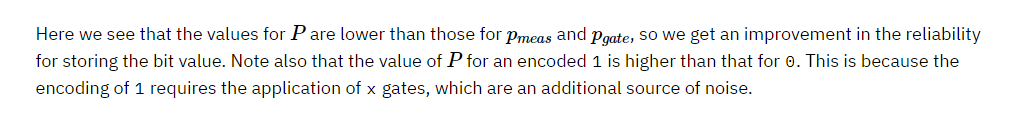

# Graph Theoretic Decoding

In [13]:
code = RepetitionCode(3,2)

raw_results = get_raw_results(code,noise_model)

results = code.process_results( raw_results )

for log in ['0','1']:
    print('\nLogical ' + log + ':')
    print('raw results       ', {string:raw_results[log][string] for string in raw_results[log] if raw_results[log][string]>=50 })
    print('processed results ', {string:results[log][string] for string in results[log] if results[log][string]>=50 })


Logical 0:
raw results        {'000 00 00': 526, '000 00 01': 58}
processed results  {'0 0  00 00 00': 526, '0 0  01 01 00': 58}

Logical 1:
raw results        {'111 01 00': 62, '111 00 00': 462, '111 10 00': 51}
processed results  {'1 1  00 01 01': 62, '1 1  00 00 00': 462, '1 1  00 10 10': 51}
